The work below relates to sections **Hot polaron states** and **Carrier cooling: heat transfer to the lattice** of the 2017 publication _Slow cooling of hot polarons in halide perovskite solar cells_. The notebook was written by Lucy D. Whalley.

In [1]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline

In [2]:
# constants in SI
m = 9.10938291E-31 # mass of electron
q = 1.60217657E-19 # charge of electron
ε = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # plancks magical number
hbar = 1.054571800E-34 # reduced planck
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23

# units in SI
Å = 1E-10 # m to angstrom
k = 1.38064852E-23

In [3]:
# matplotlib parameters
mpl.rcParams.update({'font.size': 24})
plt.rcParams["font.family"] = "serif"
mpl.rcParams['axes.linewidth'] = 1 
mpl.rcParams['xtick.major.width'] = 1 
mpl.rcParams['ytick.major.width'] = 1 

### Calculate polaron temperature in CH<sub>3</sub>NH<sub>3</sub>PbI<sub>3</sub> (MAPI) as a function of polaron radius and incoming photon energy

- Using polaron theory we have calculated the radius of the polaron (26.8Å). This provides an upper limit as disorder will increase localisation of the charge carrier. 
- We assume equipartition of the above bandgap energy between electron and hole. Near-UV excitation at 4eV gives a maximum energy of 1.2eV which can be transferred to the polaron.
- The heat capacity can be calculated from the bulk phonon density of states

The information above is enough to calculate the polaron temperature, as is done below.

In [4]:
def polaron_temperature(radius,energy,heat_capacity,lattice_constant):
    # calculate temperature given polaron properties
    volume_polaron = (4/3)*math.pi*(radius**3)
    volume_one_mole = avogadro*((lattice_constant)**3) 
    moles = volume_polaron / volume_one_mole
    temperature = energy / (heat_capacity*moles)
    return temperature # in K measured above bulk temperature

heat capacity is 120.60668096444826 J/mol/K


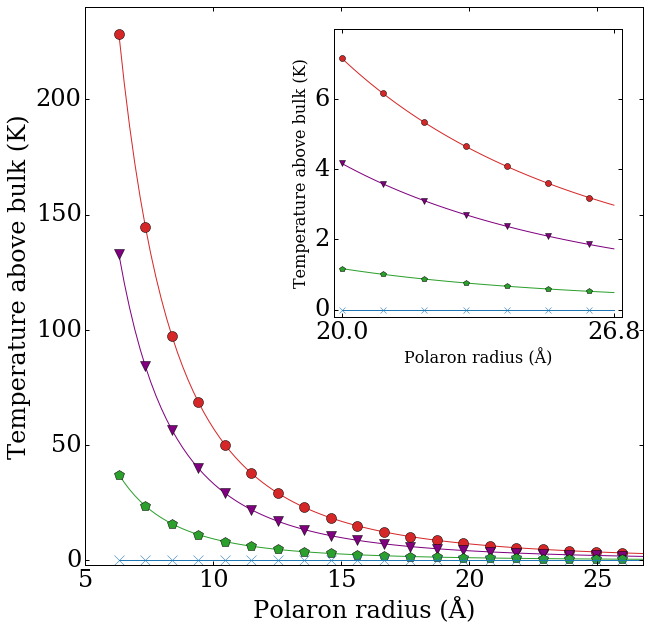

In [5]:
# MAPI lattice constant from neutron diffraction, doi:10.1038/srep35685
d = 6.306*Å
# MAPI bandgap from experimental (300 K), doi:10.7567/APEX.7.032302
ε_g = 1.61
# MAPI heat capacity
heat_capacity = 1.25 # value calculated from bulk phonon density of states, meV/unit cell/K
heat_capacity = (1.25/1000)*q # J/unit cell/K
heat_capacity = heat_capacity*avogadro # J/mol/K
print("heat capacity is %s J/mol/K"%heat_capacity)

photon_energies = [(x - ε_g)*q for x in [1.61,2,3,4]]

colours = ["#d62728","purple","#2ca02c","#1f77b4"]
marker = ['o','v','p','x']

## PLOT
fig = plt.figure(figsize=(10,10))
counter = 0
for energy in reversed(photon_energies):
    temperature = []
    for radius in np.linspace(d,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d)) # divide by two as half goes to electron
    plt.plot((np.linspace(d,26.8*Å,100))/Å,temperature,color = colours[counter],marker=marker[counter],markevery=5,markersize=10)
    counter += 1
plt.xlim([6.306,26.8])
plt.ylim([-2,240])
plt.xticks([5,10,15,20,25]) 
plt.xlabel("Polaron radius (Å)")
plt.ylabel("Temperature above bulk (K)")


## PLOT INSET
a = plt.axes(([.47, .47, .4, .4]))
counter = 0    
for energy in reversed(photon_energies) :
    temperature = []
    for radius in np.linspace(20*Å,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d))
    plt.plot((np.linspace(20*Å,26.8*Å,100))/Å,temperature,color = colours[counter],marker=marker[counter], markevery=15)
    counter += 1
plt.xlim([19.8,27])
plt.ylim([-0.2,8])
plt.xticks([20,26.8])
plt.yticks([0,2,4,6])
plt.xlabel("Polaron radius (Å)",fontsize=16)
plt.ylabel("Temperature above bulk (K)",fontsize=16)

plt.savefig("TempVsRadius.pdf",bbox_inches='tight',format="pdf",dpi=500)


### Calculate Polaron temperature as a function of time and material diffusivity

- We consider individual phonon quanta being absorbed into isolated hot polarons (low fluence limit)
- We consider the polaron as a hot sphere in a continuum of ambient temperature material, this allows us to calculate temperature as a function of time using the classical heat diffusion equation.

In [6]:
def crank_diffusion_sphere(initial_energy,polaron_radius,D,position,time):
    # D is diffusivity
    # Returns energy at a given position and time
    # Expression for diffusion. For derivation see notebook "diffusion_eqn_for_hot_sphere.ipynb"
    return 0.5*initial_energy*(math.erf((polaron_radius+position)/np.sqrt(4*D*time)) + math.erf((polaron_radius-position)/np.sqrt(4*D*time))) - ((initial_energy/position)*np.sqrt(D*time/math.pi)*(math.exp(-((polaron_radius-position)**2)/(4*D*time))-math.exp(-((polaron_radius+position)**2)/(4*D*time))))

In [7]:
def diffusivity(thermal_conductivity, lattice_const, molecular_weight,heat_cap):
    # heat_cap suuplied in popular J/mol/k units.
    # Returns diffusivity of material
    # diffusivity = thermal_conductivity / (density*heat capacity)
    density = (molecular_weight/avogadro) / (lattice_const**3) # g/m^3 
    heat_capacity_g = heat_capacity / molecular_weight # convert heat capacity to J/g/K
    return thermal_conductivity / (density*heat_capacity_g) # m^2/s

In [8]:
def calculate_energy(diffusivity):
    # calculate energy of polaron in material of given diffusivity
    energy = []
    for time in time_steps:
        data = []
        # take a weighted average temperature across the polaron
        for position in (np.linspace(1E-20,+polaron_radius,10)):
            data.append(crank_diffusion_sphere(initial_energy,polaron_radius,diffusivity,position,time))
        w = np.multiply(np.linspace(0,+polaron_radius,10),np.linspace(0,+polaron_radius,10))
        energy.append(np.average(data,weights=w))
    return energy

In [9]:
## polaron properties
polaron_radius = 26.8*Å
initial_energy = 1.2 # temperature for a polaron in MAPI with a radius of 26.8Å, excited by 1.2eV

## time steps for x-axis
time_steps = np.logspace(-19,-8,30000)

In [10]:
## MAPI
d = 6.306*Å # m
molecular_weight = 619.98 # g/mole
heat_capacity = 120 # J/mol/k, see calculation above
thermal_conductivity = 0.05 # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print (r"Diffusivity is %E m^2/s"%D)

energy_MAPI = calculate_energy(D)

Diffusivity is 6.292187E-08 m^2/s


In [11]:
## CdTe
d = 6.48*Å
molecular_weight = 240.01 # g/mole
heat_capacity = 38.9  # J/mol/k, from experimental
thermal_conductivity = 9  # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E m^2/s"%D)

energy_CdTe = calculate_energy(D)

Diffusivity is 3.791132E-05 m^2/s


In [12]:
## GaAs
d = 5.65*Å
molecular_weight = 144.645 # g/mole
heat_capacity = 47 # J/mol/K, from experimental
thermal_conductivity = 38 # W.m-1.k-1, taken from https://doi.org/10.1103/PhysRevB.94.220301
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E m^2/s"%D)

energy_GaAs = calculate_energy(D)

Diffusivity is 8.781770E-05 m^2/s


In [13]:
## CsPbI3
d = 6.29*Å 
molecular_weight = 720.82 # g/mole
heat_capacity = 31 # J/mol/K, from phonon DOS
thermal_conductivity = 0.5 # W.m-1.k-1, as calculated in the paper
D = diffusivity(thermal_conductivity,d,molecular_weight,heat_capacity)
print ("Diffusivity is %E m^2/"%D)

energy_CsPbI3 = calculate_energy(D)

Diffusivity is 2.417192E-06 m^2/


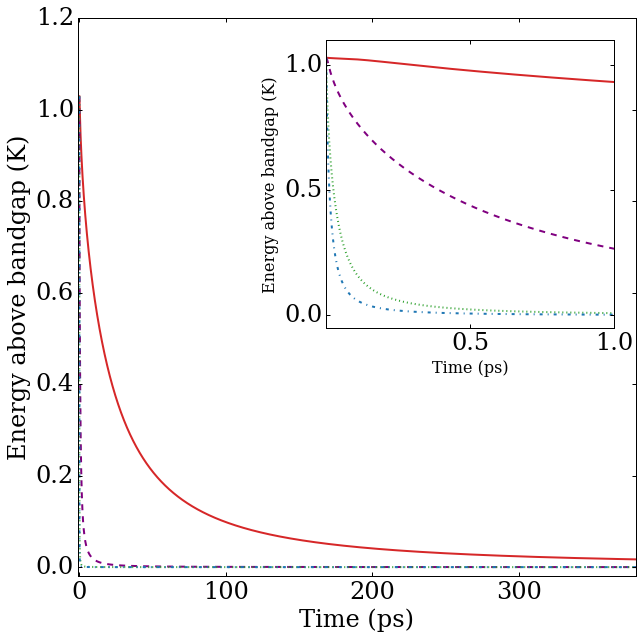

In [20]:
# PLOT
fig = plt.figure(figsize=(10,10))
plt.plot(time_steps/1E-12,energy_MAPI,color="#d62728",ls="-",linewidth="2")
plt.plot(time_steps/1E-12,energy_CsPbI3,color="purple",ls="--",linewidth="2")
plt.plot(time_steps/1E-12,energy_CdTe,color="#2ca02c",ls=":",linewidth="2")
plt.plot(time_steps/1E-12,energy_GaAs,color="#1f77b4",ls="-.",linewidth="2")
plt.xlabel("Time (ps)")
plt.xlim([-1,380])
plt.xticks([0,100,200,300])
plt.ylabel("Energy above bandgap (K)")
plt.ylim([-0.02,1.2])
plt.yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])

a = plt.axes(([.47, .47, .4, .4]))
plt.plot(time_steps/1E-12,energy_MAPI,color="#d62728",ls="-",linewidth="2")
plt.plot(time_steps/1E-12,energy_CsPbI3,color="purple",ls="--",linewidth="2")
plt.plot(time_steps/1E-12,energy_CdTe,color="#2ca02c",ls=":",linewidth="2")
plt.plot(time_steps/1E-12,energy_GaAs,color="#1f77b4",ls="-.",linewidth="2")
plt.xlabel("Time (ps)",fontsize=16)
plt.xlim([0.0,1])
plt.ylim([-0.05,1.1])
plt.xticks([0.5,1.0])
plt.ylabel("Energy above bandgap (K)",fontsize=16)
plt.yticks([0,0.5,1.0])

plt.savefig("EnergyVsTime.pdf",bbox_inches='tight',format="pdf",dpi=500)